In [1]:
from astropy.io import fits
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.vq import vq, kmeans
import scipy
from astroquery.gaia import Gaia
import os

import match

# Global Parameters
BAND = 'i'
PSF_DATA_FILEPATH = "../../psf_data/psf_y3a1-v29.fits"
RESULTS_FILEPATH = "../results/"
TOTAL_SUBSAMPLE_SIZE = 10000
CLUSTER_SUBSAMPLE_SIZE = 1000
NUMBER_OF_CLUSTERS = 500
MATCH_LIM = 1 * u.arcsec
INT_DATA_PATH = "../../int_data/"

In [2]:
def read_des_fits(file_path, band, n = int(1e6)):
    """
    Read in the DES fits file and return a pandas dataframe with ra, dec, mag and band columns.
    Args: 
        file_path: path to the fits file
        band: band to be read in
        n: subsample of stars to be read in within specified band
    Returns:
        des: pandas dataframe with ra, dec, mag and band columns
    """
    
    # Read in the fits file and close it
    hdul = fits.open(file_path)
    
    # hdul[1].data is a numpy recarray. Get the ra, dec, mag and band columns   
    cols = ['ra', 'dec', 'mag', 'band']
    zidx = np.random.choice(np.where(hdul[1].data['band'] == band)[0], size = n, replace = False)
    data = {col: hdul[1].data[col][zidx] for col in cols}
    hdul.close()

    des = pd.DataFrame(data)
    

    # Combine ra and dec into a sky coord array
    des['coord'] = SkyCoord(ra=des['ra'], dec=des['dec'], unit = 'deg')
    return des

print("Starting DES Gaia Crossmatch for Band " + str(BAND) + ".")

# Read in DES Data
des = read_des_fits(PSF_DATA_FILEPATH, BAND, n = TOTAL_SUBSAMPLE_SIZE)
print("Data read in.")

Starting DES Gaia Crossmatch for Band i.
Data read in.


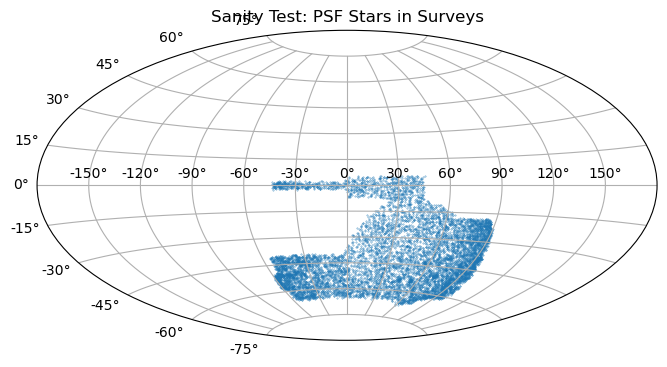

In [31]:
# Plot location of subsample of PSF stars
match.plot_sanity_test(des['coord'], fold = RESULTS_FILEPATH, BAND = BAND)

In [32]:
# Perform clustering on subsample of PSF stars, use on full sample
centroids = match.perform_clustering(des, NUMBER_OF_CLUSTERS, CLUSTER_SUBSAMPLE_SIZE)

Centroids found.


<Figure size 640x480 with 0 Axes>

In [33]:
# Save centroids array to int_data
np.save(INT_DATA_PATH + "centroids.npy", centroids)

In [24]:
import importlib
importlib.reload(match)

<module 'match' from '/home/shrihan/weaklens/gaia_match_psf/gaia_match_psf_code/src/match.py'>

In [13]:
cluster_num_array, cluster_info = match.get_assignments(data, centroids)

Stars clustered.


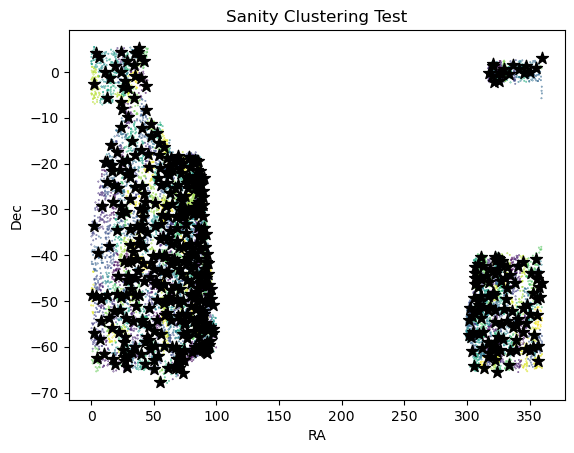

In [14]:
# Plot the clusters with color
match.plot_cluster_test(ra_dec, centroids, cluster_num_array, fold = RESULTS_FILEPATH, BAND = BAND)

In [6]:
# Match Gaia for stars in the clusters 
for i in range(NUMBER_OF_CLUSTERS):
    print("Cluster " + str(i) + ":", end = ' ')
    comb_clusteri = match.match_cluster_to_gaia(des, cluster_num_array, ra_dec, cluster_info, i)
    print("Matched.")
    comb_clusteri.to_csv(INT_DATA_PATH + "cluster_" + str(BAND) + "_" + str(i) + ".csv")

Cluster 0: R = 1.593 | Queried. Matched.
Cluster 1: R = 3.447 | 

KeyboardInterrupt: 

In [8]:
# Concatenate all the clusters
master_comb_df = match.concatenate_int_data(INT_DATA_PATH)
master_comb_df.to_csv(RESULTS_FILEPATH + "DES_MATCH_BAND" + str(BAND) + ".csv")
print("Concatenated Master DF.")

Concatenated Master DF.


In [3]:
master_comb_df = pd.read_csv(RESULTS_FILEPATH + "DES_MATCH_BAND" + str(BAND) + ".csv")

/home/shrihan/weaklens/gaia_match_psf/gaia_match_psf_code/src/match.py:299: RuntimeWarning: invalid value encountered in divide
  plt.bar(mid(failed_star_galaxy_cut[1]), failed_star_galaxy_cut[0] / all_match[0], label = "Fraction Matched Failing Star-Galaxy Cut",color = "orange", width=0.14)
/home/shrihan/weaklens/gaia_match_psf/gaia_match_psf_code/src/match.py:300: RuntimeWarning: invalid value encountered in divide
  plt.bar(mid(galaxy_match[1]), galaxy_match[0] / all_match[0], label = "Fraction Matched Gaia Galaxy Candidates",color = "green", width=0.14)
/home/shrihan/weaklens/gaia_match_psf/gaia_match_psf_code/src/match.py:308: RuntimeWarning: invalid value encountered in divide
  plt.bar(mid(failed_star_galaxy_cut[1]), failed_star_galaxy_cut[0] / all_match[0], label = "Fraction Matched Failing Star-Galaxy Cut",color = "orange", width=0.14)
/home/shrihan/weaklens/gaia_match_psf/gaia_match_psf_code/src/match.py:309: RuntimeWarning: invalid value encountered in divide
  plt.bar(mid(g

Plotting Complete.


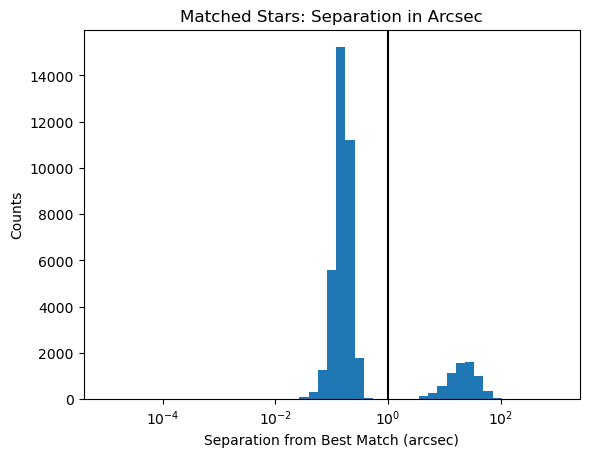

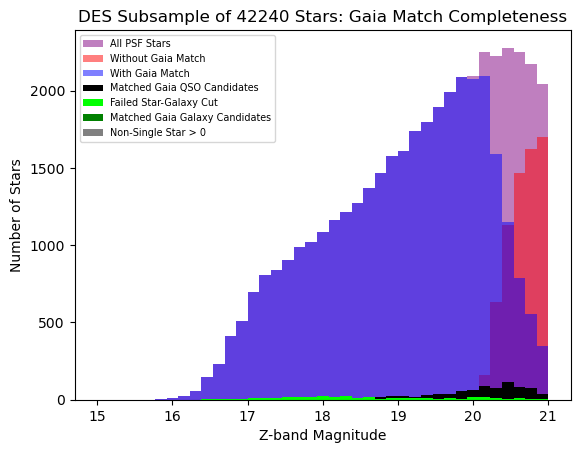

<Figure size 640x480 with 0 Axes>

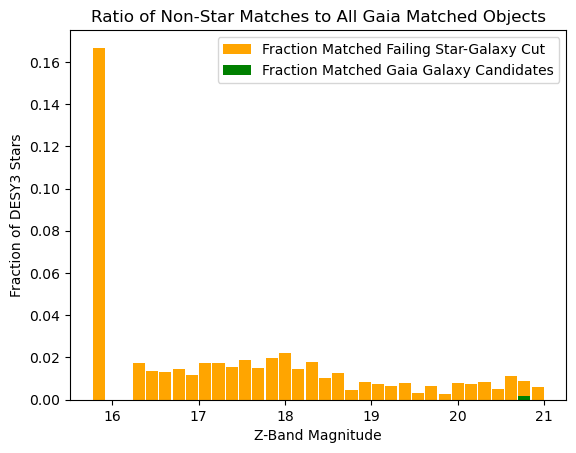

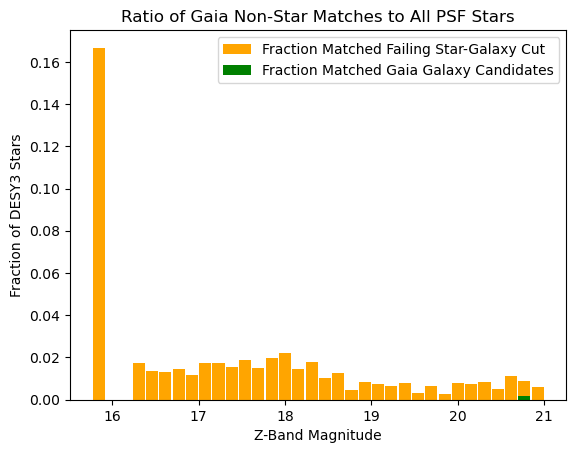

In [4]:
# Plot matching tests and results
match.sanity_separation_test(master_comb_df, fold = RESULTS_FILEPATH, BAND = BAND)
match.plot_match_completeness(master_comb_df, fold = RESULTS_FILEPATH, BAND = BAND)
match.galaxy_ratio_plot(master_comb_df, fold = RESULTS_FILEPATH, BAND = BAND)
print("Plotting Complete.")